<a href="https://colab.research.google.com/github/alsrl9606/deep/blob/main/LSTM%EC%9D%84_%ED%99%9C%EC%9A%A9%ED%95%9C_%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facebook Prophet을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- Facebook Prophet을 활용하여 주가 예측

## 필요한 모듈 import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [ ]:
# !pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

In [ ]:
# 삼성전자 종목코드: 005930
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [ ]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-12-23,72400,74000,72300,73900,19411326,0.022130
2020-12-24,74100,78800,74000,77800,32502870,0.052774
2020-12-28,79000,80100,78200,78700,40085044,0.011568
2020-12-29,78800,78900,77300,78300,30339449,-0.005083
2020-12-30,77400,81300,77300,81000,29122199,0.034483


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [ ]:
# 비트코인 시세
btc = fdr.DataReader('BTC/KRW', '2019-01-01', '2020-12-01')
btc

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-01-01,4289000,4199000,4300000,4137000,3230.0,0.0214
2019-01-02,4345000,4294000,4360000,4244000,3860.0,0.0131
2019-01-03,4282000,4352000,4367000,4259000,15370.0,-0.0145
2019-01-04,4309000,4286000,4334000,4243000,19200.0,0.0063
2019-01-05,4297000,4309000,4354000,4278000,24870.0,-0.0028
...,...,...,...,...,...,...
2020-11-27,19119000,19236000,19236000,19119000,1440.0,-0.0067
2020-11-28,19480000,19118000,19480000,19118000,1610.0,0.0189
2020-11-29,20002000,19480000,20002000,19281000,830.0,0.0268


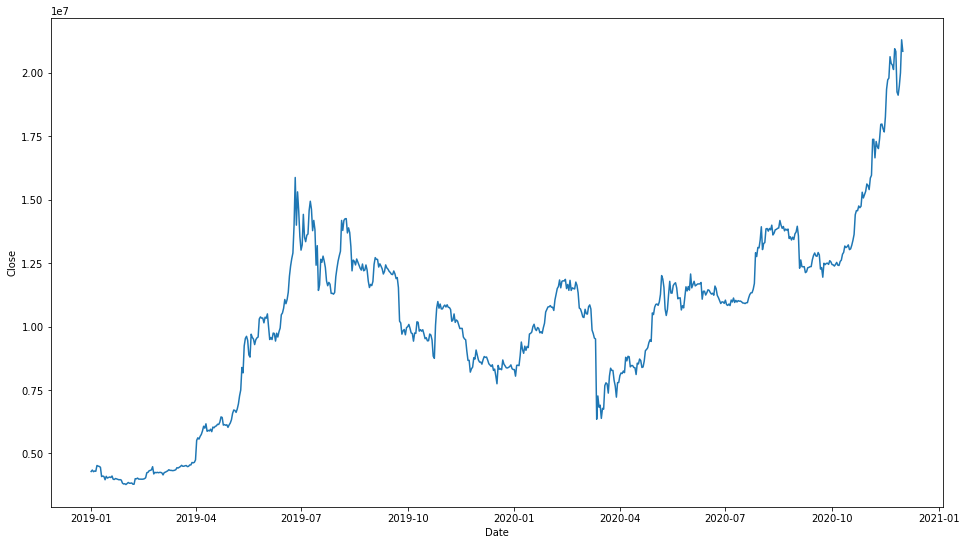

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(x=btc.index, y='Close', data=btc)
plt.show()

## 시각화

Text(0, 0.5, 'price')

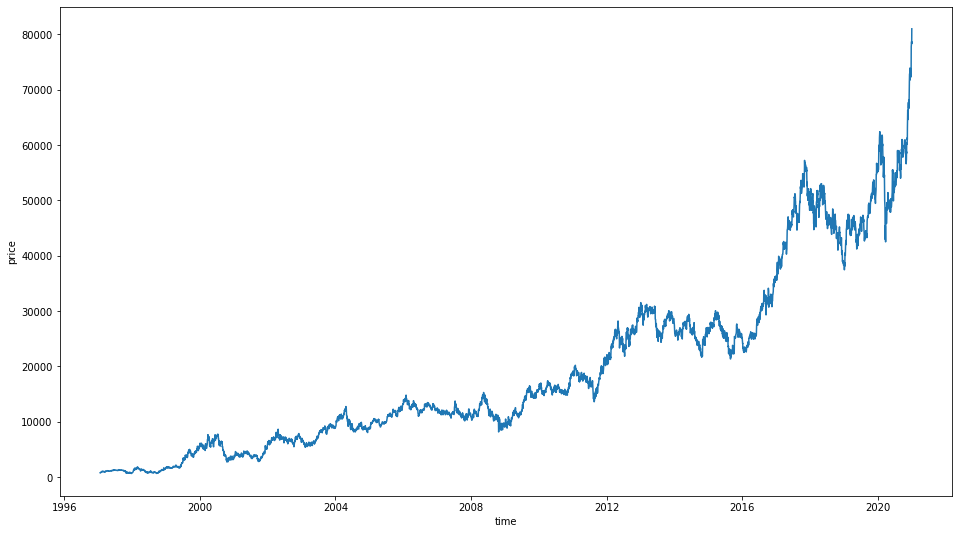

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

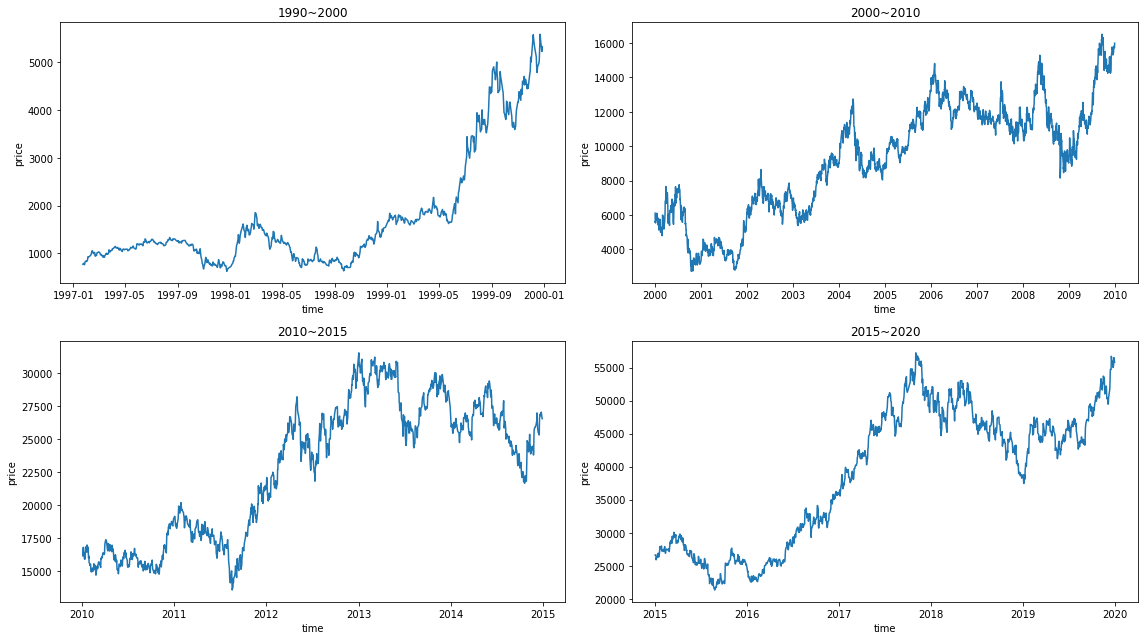

In [ ]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

In [ ]:
stock = fdr.DataReader(STOCK_CODE, '2019')

## Prophet

### 모듈 import

In [ ]:
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

### 컬럼

- 반드시 **y** 컬럼과 **ds** 컬럼이 존재해야합니다.
- 예측 값은 **y**, 시계열 데이터는 **ds**에 지정합니다.

In [ ]:
stock['y'] = stock['Close']
stock['ds'] = stock.index

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Change,y,ds
Date,,,,,,,,
2019-01-02,39400,39400,38550,38750,7847664,0.001292,38750,2019-01-02
2019-01-03,38300,38550,37450,37600,12471493,-0.029677,37600,2019-01-03
2019-01-04,37450,37600,36850,37450,14108958,-0.003989,37450,2019-01-04
2019-01-07,38000,38900,37800,38750,12748997,0.034713,38750,2019-01-07
2019-01-08,38000,39200,37950,38100,12756554,-0.016774,38100,2019-01-08


### prophet 객체 선언 및 학습

In [ ]:
m = Prophet()
m.fit(stock)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**period**에 예측 하고 싶은 기간을 입력 합니다.

예측할 시계열 row가 추가 됩니다.

In [ ]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
519,2021-01-25
520,2021-01-26
521,2021-01-27
522,2021-01-28
523,2021-01-29


- `predict`로 예측을 진행합니다.
- `predict` 안에는 이전 단계에서 만들어준 future 데이터프레임을 입력합니다.


In [ ]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
519,2021-01-25,73285.088050,70675.062276,76794.171605,72957.252622,73545.419311,469.630675,469.630675,469.630675,469.630675,469.630675,469.630675,0.0,0.0,0.0,73754.718725
520,2021-01-26,73395.948372,70933.659222,77589.754289,73056.654128,73686.157995,726.870827,726.870827,726.870827,726.870827,726.870827,726.870827,0.0,0.0,0.0,74122.819199
521,2021-01-27,73506.808693,71021.256940,77596.069570,73137.054703,73817.468945,792.284285,792.284285,792.284285,792.284285,792.284285,792.284285,0.0,0.0,0.0,74299.092978
522,2021-01-28,73617.669015,71181.323863,77633.480694,73225.751671,73968.220768,649.781483,649.781483,649.781483,649.781483,649.781483,649.781483,0.0,0.0,0.0,74267.450498
523,2021-01-29,73728.529336,71180.811421,77629.682966,73313.025270,74098.740931,557.043551,557.043551,557.043551,557.043551,557.043551,557.043551,0.0,0.0,0.0,74285.572887


In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-40:-20]

,ds,yhat,yhat_lower,yhat_upper
484,2020-12-16,69642.959477,66518.925485,72840.938327
485,2020-12-17,69611.316997,66625.996969,72937.576822
486,2020-12-18,69629.439387,66395.284304,73016.201241
487,2020-12-21,69874.607474,66606.356902,73124.107623
488,2020-12-22,70242.707948,66981.027713,73559.871373
489,2020-12-23,70418.981727,67199.323821,73753.781182
490,2020-12-24,70387.339247,67345.605359,73439.653954
491,2020-12-28,70650.629725,67668.833830,73710.672639
492,2020-12-29,71018.730198,67590.637354,74106.859227
493,2020-12-30,71195.003978,68016.027153,74470.641272


### 시각화

`plot`은 트렌드와 함께 예측된 결과물을 시각화하여 보여줍니다.

In [ ]:
fig = m.plot(forecast)

NameError: ignored

### plotly 활용

In [ ]:
fig = plot_plotly(m, forecast)
fig

NameError: ignored

### 컴포넌트 별 시각화

컴포넌트 별 시각화에서는 seasonality 별 시각화를 진행해 볼 수 있습니다.

**trend, yearly, weekly 데이터를 시각화**하여 보여 줍니다.

In [ ]:
plot_components_plotly(m, forecast)

NameError: ignored

### change points

By default, Prophet specifies 25 potential changepoints which are uniformly placed in the first 80% of the time series. The vertical lines in this figure indicate where the potential changepoints were placed:

처음 80%의 시계열 데이터에 대하여 잠재적인 25개의 changepoints를 만들고, 그 중 선별하여 최종 changepoints를 그래프에서 vertical line으로 그려주게 됩니다.

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

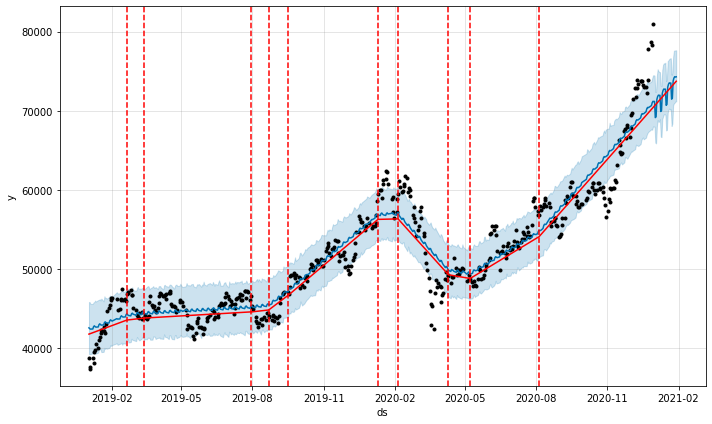

In [ ]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### flexibility 조절

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. By default, this parameter is set to 0.05. Increasing it will make the trend more flexible:

flexibility **계수가 낮으면 과소적합, 높으면 과대적합**하여 예측하게 됩니다.

중요한 hyperparameter 입니다.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


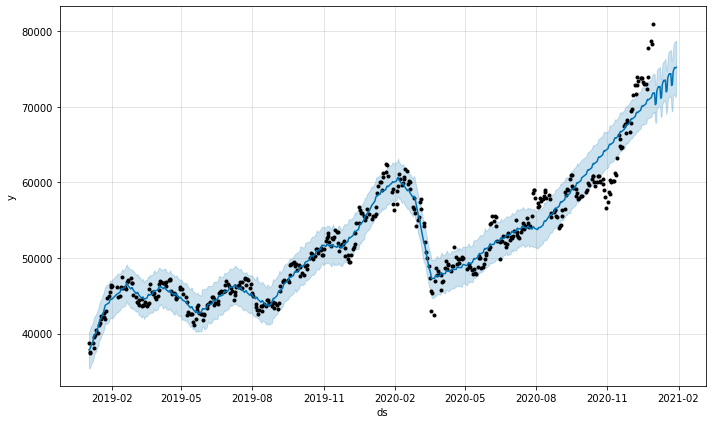

In [ ]:
m = Prophet(changepoint_prior_scale=0.8)
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


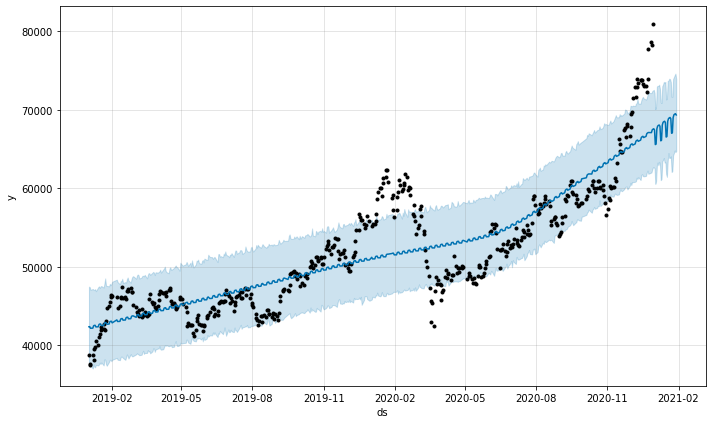

In [ ]:
m = Prophet(changepoint_prior_scale=0.01)
forecast = m.fit(stock).predict(future)
fig = m.plot(forecast)